In [ ]:
import os
import tensorflow as tf

print("Datensatzpfad:")
print(os.listdir("garbage-dataset"))


TensorFlow-Version: 2.19.0
Datensatzpfad:
['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


In [ ]:
import os
import shutil
import random
from tqdm import tqdm

# Originalpfad
original_dataset_dir = "garbage-dataset"

# Zielverzeichnis
base_dir = "garbage-dataset-split"
os.makedirs(base_dir, exist_ok=True)

# Aufteilungsraten
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Alle Kategorien (Verzeichnisnamen)
classes = os.listdir(original_dataset_dir)

# Für jede Klasse aufteilen
for class_name in tqdm(classes, desc="Verarbeite Klassen"):
    class_dir = os.path.join(original_dataset_dir, class_name)
    images = os.listdir(class_dir)
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    n_test = n_total - n_train - n_val  # Rest
    
    splits = {
        "train": images[:n_train],
        "val": images[n_train:n_train + n_val],
        "test": images[n_train + n_val:]
    }

    for split_name, split_images in splits.items():
        split_dir = os.path.join(base_dir, split_name, class_name)
        os.makedirs(split_dir, exist_ok=True)

        for img in split_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(split_dir, img)
            shutil.copyfile(src, dst)

print("Datenaufteilung abgeschlossen.") 
#hat evtl. einen überflüssigen Ordner erstellt, den man rauslöschen muss

Verarbeite Klassen: 100%|██████████| 10/10 [03:07<00:00, 18.76s/it]

Datenaufteilung abgeschlossen.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Basisverzeichnis mit den gesplitteten Daten
base_dir = "garbage-dataset-split"

# ImageDataGenerator für Trainingsdaten mit Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Für Validation und Test nur Normalisierung
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Trainingsdaten generieren
train_generator = train_datagen.flow_from_directory(
    directory=f"{base_dir}/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

# Validierungsdaten generieren
val_generator = val_test_datagen.flow_from_directory(
    directory=f"{base_dir}/val",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

# Testdaten generieren
test_generator = val_test_datagen.flow_from_directory(
    directory=f"{base_dir}/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 13827 images belonging to 10 classes.
Found 2961 images belonging to 10 classes.
Found 2974 images belonging to 10 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

C:\Users\rusla\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,250 (42.61 MB)

 Trainable params: 11,170,250 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

C:\Users\rusla\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 461s 1s/step - accuracy: 0.3192 - loss: 2.0810 - val_accuracy: 0.4948 - val_loss: 1.4609
Epoch 2/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 358s 827ms/step - accuracy: 0.4481 - loss: 1.5995 - val_accuracy: 0.5562 - val_loss: 1.2984
Epoch 3/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 360s 831ms/step - accuracy: 0.4926 - loss: 1.4897 - val_accuracy: 0.5849 - val_loss: 1.2220
Epoch 4/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 353s 814ms/step - accuracy: 0.5252 - loss: 1.4030 - val_accuracy: 0.5799 - val_loss: 1.2149
Epoch 5/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 345s 798ms/step - accuracy: 0.5330 - loss: 1.3574 - val_accuracy: 0.5640 - val_loss: 1.2609
Epoch 6/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 355s 819ms/step - accuracy: 0.5334 - loss: 1.3661 - val_accuracy: 0.6109 - val_loss: 1.1131
Epoch 7/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 325s 749ms/step - accuracy: 0.5643 - loss: 1.2714 - val_accuracy: 0.6363 - val_loss: 1.0731
Epoch 8/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 325s 750ms/step - accuracy: 0.5702 - lo

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Modell-Architektur
own_cnn_model2 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),  #weitere Schicht
    BatchNormalization(),
    MaxPooling2D(2,2),

    GlobalAveragePooling2D(),  # statt Flatten
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

own_cnn_model2.summary()

# Kompilieren
own_cnn_model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)

# Training
history2 = own_cnn_model2.fit(
    train_generator,  
    epochs=25,
    validation_data=val_generator,
    callbacks=[early_stop, lr_reduce]
)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 424,522 (1.62 MB)

 Trainable params: 423,562 (1.62 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/25
433/433 ━━━━━━━━━━━━━━━━━━━━ 696s 2s/step - accuracy: 0.3620 - loss: 1.9518 - val_accuracy: 0.4704 - val_loss: 1.5596 - learning_rate: 0.0010
Epoch 2/25
433/433 ━━━━━━━━━━━━━━━━━━━━ 704s 2s/step - accuracy: 0.4758 - loss: 1.5324 - val_accuracy: 0.3712 - val_loss: 2.0517 - learning_rate: 0.0010
Epoch 3/25
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5139 - loss: 1.4376
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
433/433 ━━━━━━━━━━━━━━━━━━━━ 702s 2s/step - accuracy: 0.5140 - loss: 1.4375 - val_accuracy: 0.4681 - val_loss: 1.5795 - learning_rate: 0.0010
Epoch 4/25
433/433 ━━━━━━━━━━━━━━━━━━━━ 702s 2s/step - accuracy: 0.5646 - loss: 1.2829 - val_accuracy: 0.6008 - val_loss: 1.1810 - learning_rate: 5.0000e-04
Epoch 5/25
433/433 ━━━━━━━━━━━━━━━━━━━━ 703s 2s/step - accuracy: 0.6037 - loss: 1.1959 - val_accuracy: 0.5633 - val_loss: 1.3599 - learning_rate: 5.0000e-04
Epoch 6/25
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6307 - loss:

93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 271ms/step


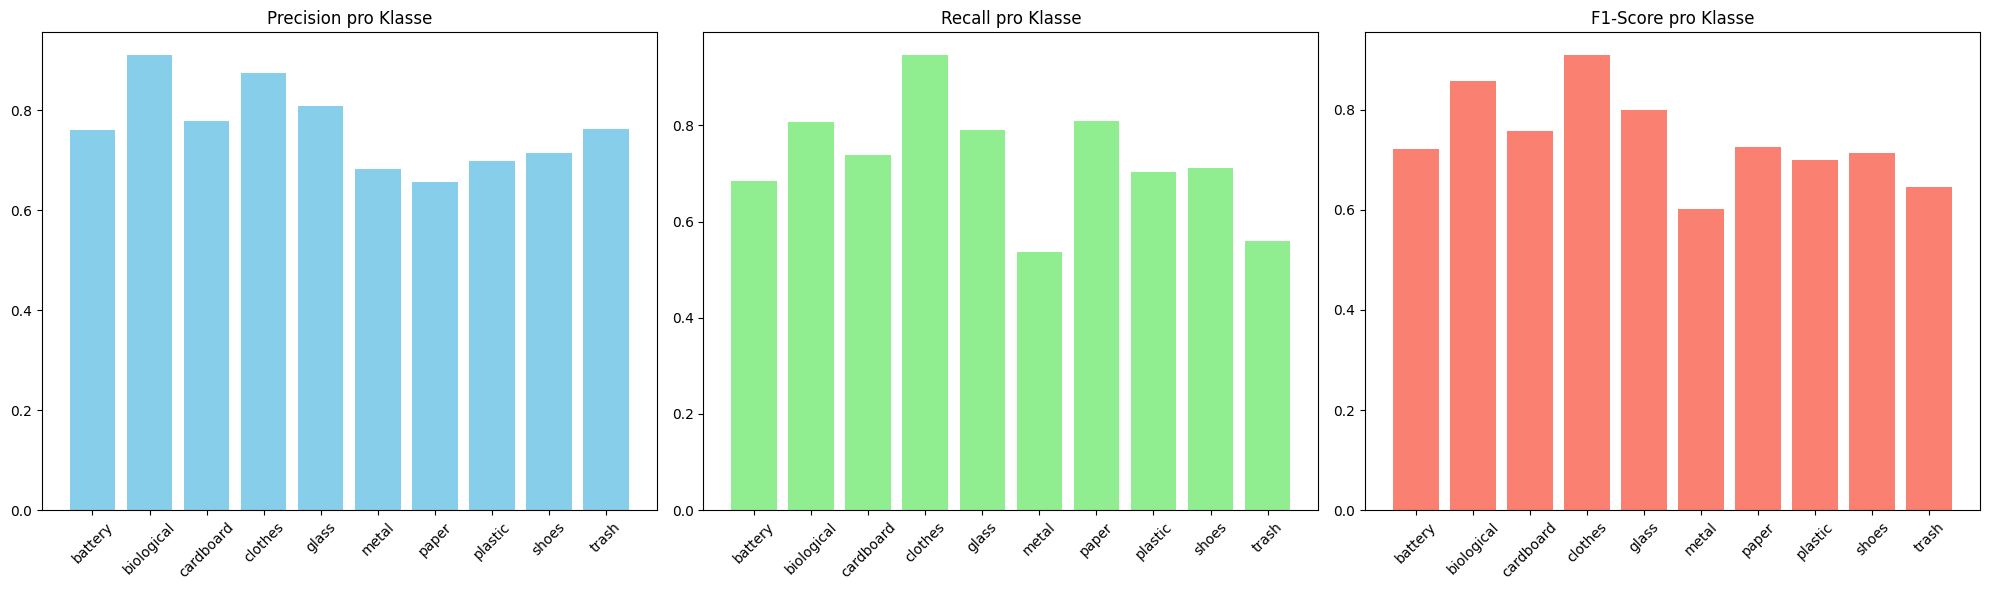

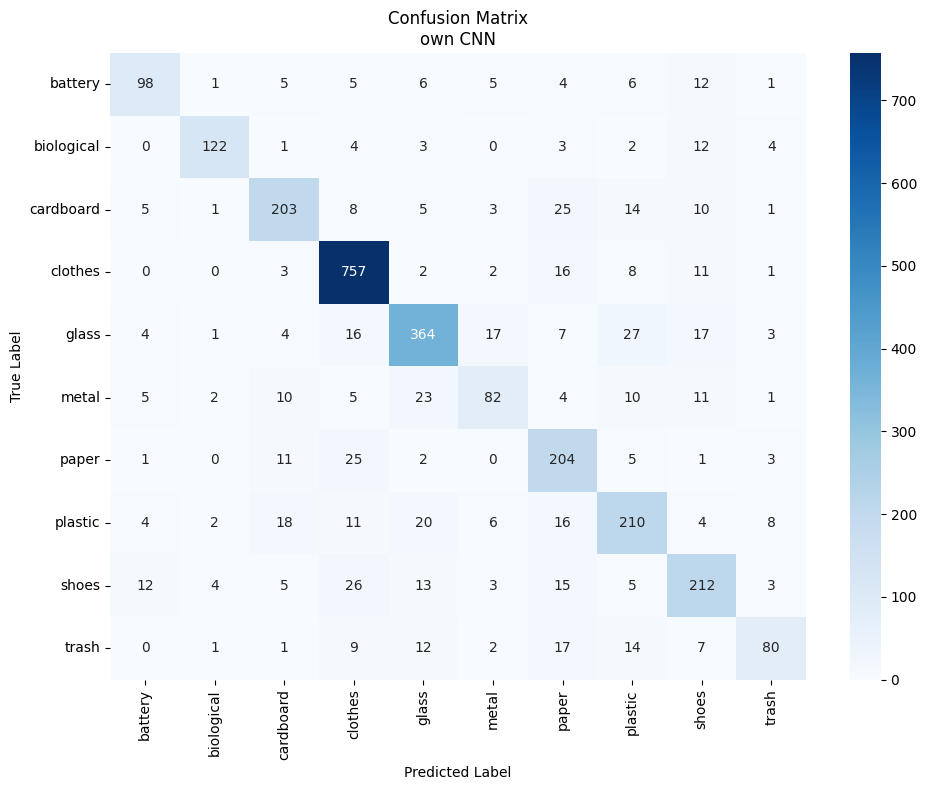

In [67]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ==== Hilfsfunktionen ====

def get_metrics(y_true, y_pred, class_names):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, zero_division=0)
    return pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

def plot_confusion_matrix(cm, class_names, model_name, ax):
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(f'Confusion Matrix\n{model_name}')

def evaluate_and_plot(own_cnn_model2, test_generator, class_names, model_name):
    y_pred = own_cnn_model2.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes
    
    metrics_df = get_metrics(y_true, y_pred_classes, class_names)
    cm = confusion_matrix(y_true, y_pred_classes)
    
    return metrics_df, cm

# ==== Modellbewertung ====

# Klassennamen aus dem Generator holen
class_names = list(test_generator.class_indices.keys())

# Evaluate dein neues EfficientNet-Modell
metrics_own_cnn, cm_own_cnn = evaluate_and_plot(own_cnn_model2, test_generator, class_names, "own CNN")

# ==== Plotten ====

# Barplot mit Precision, Recall, F1
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
x = np.arange(len(class_names))

axs[0].bar(x, metrics_own_cnn['Precision'], color='skyblue')
axs[0].set_xticks(x)
axs[0].set_xticklabels(class_names, rotation=45)
axs[0].set_title('Precision pro Klasse')

axs[1].bar(x, metrics_own_cnn['Recall'], color='lightgreen')
axs[1].set_xticks(x)
axs[1].set_xticklabels(class_names, rotation=45)
axs[1].set_title('Recall pro Klasse')

axs[2].bar(x, metrics_own_cnn['F1-Score'], color='salmon')
axs[2].set_xticks(x)
axs[2].set_xticklabels(class_names, rotation=45)
axs[2].set_title('F1-Score pro Klasse')

plt.tight_layout()
plt.show()

# Confusion Matrix plotten
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cm_own_cnn, class_names, "own CNN", plt.gca())
plt.tight_layout()
plt.show()


In [68]:
import numpy as np
from sklearn.metrics import classification_report

# Vorhersagen (Wahrscheinlichkeiten) → in Klassen umwandeln
y_pred_probs = own_cnn_model2.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Wahre Labels extrahieren
y_true = test_generator.classes

# Klassennamen aus dem Generator holen (optional)
class_names = list(test_generator.class_indices.keys())

# Bericht ausgeben
print(classification_report(y_true, y_pred, target_names=class_names))


93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 263ms/step
              precision    recall  f1-score   support

     battery       0.76      0.69      0.72       143
  biological       0.91      0.81      0.86       151
   cardboard       0.78      0.74      0.76       275
     clothes       0.87      0.95      0.91       800
       glass       0.81      0.79      0.80       460
       metal       0.68      0.54      0.60       153
       paper       0.66      0.81      0.72       252
     plastic       0.70      0.70      0.70       299
       shoes       0.71      0.71      0.71       298
       trash       0.76      0.56      0.65       143

    accuracy                           0.78      2974
   macro avg       0.76      0.73      0.74      2974
weighted avg       0.78      0.78      0.78      2974



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# MobileNetV2 laden ohne Klassifikationskopf
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Basis-Modell einfrieren, nur neuer Kopf trainierbar
base_model.trainable = False

# Modell bauen
mobilenetv2_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')  
])

mobilenetv2_model.summary()

mobilenetv2_model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

history = mobilenetv2_model.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=10)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 434s 996ms/step - accuracy: 0.6754 - loss: 1.0050 - val_accuracy: 0.8852 - val_loss: 0.3539
Epoch 2/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 426s 983ms/step - accuracy: 0.8677 - loss: 0.4093 - val_accuracy: 0.9054 - val_loss: 0.2964
Epoch 3/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 349s 807ms/step - accuracy: 0.8764 - loss: 0.3679 - val_accuracy: 0.9071 - val_loss: 0.2859
Epoch 4/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 329s 759ms/step - accuracy: 0.8835 - loss: 0.3520 - val_accuracy: 0.9213 - val_loss: 0.2601
Epoch 5/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 332s 766ms/step - accuracy: 0.8949 - loss: 0.3154 - val_accuracy: 0.9156 - val_loss: 0.2680
Epoch 6/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 332s 767ms/step - accuracy: 0.8955 - loss: 0.3078 - val_accuracy: 0.9166 - val_loss: 0.2616
Epoch 7/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 331s 765ms/step - accuracy: 0.8984 - loss: 0.3039 - val_accuracy: 0.9173 - val_loss: 0.2712
Epoch 8/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 333s 768ms/step - accuracy: 0.8980 -

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# EfficientNetB0 laden ohne Klassifikationskopf
base_efficientnet_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Basis-Modell einfrieren (nur Kopf trainierbar)
base_efficientnet_model.trainable = False

# Modell bauen
efficientnet_model = models.Sequential([
    base_efficientnet_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')  # Anzahl Klassen anpassen
])

efficientnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

efficientnet_model.summary()

# Trainieren (nur Kopf)
history = efficientnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

#hat schlecht trainiert, weil Bilder falsche Skalierung für dieses Modell hatte

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 411s 933ms/step - accuracy: 0.2526 - loss: 2.1708 - val_accuracy: 0.2698 - val_loss: 2.1546
Epoch 2/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 403s 930ms/step - accuracy: 0.2499 - loss: 2.1708 - val_accuracy: 0.2698 - val_loss: 2.1386
Epoch 3/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 408s 943ms/step - accuracy: 0.2677 - loss: 2.1588 - val_accuracy: 0.2698 - val_loss: 2.1340
Epoch 4/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 416s 961ms/step - accuracy: 0.2658 - loss: 2.1524 - val_accuracy: 0.2698 - val_loss: 2.1361
Epoch 5/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 425s 982ms/step - accuracy: 0.2598 - loss: 2.1707 - val_accuracy: 0.2698 - val_loss: 2.1410
Epoch 6/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 419s 969ms/step - accuracy: 0.2647 - loss: 2.1555 - val_accuracy: 0.2698 - val_loss: 2.1403
Epoch 7/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 411s 949ms/step - accuracy: 0.2678 - loss: 2.1503 - val_accuracy: 0.2698 - val_loss: 2.1366
Epoch 8/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 398s 918ms/step - accuracy: 0.2677 -

93/93 ━━━━━━━━━━━━━━━━━━━━ 65s 697ms/step


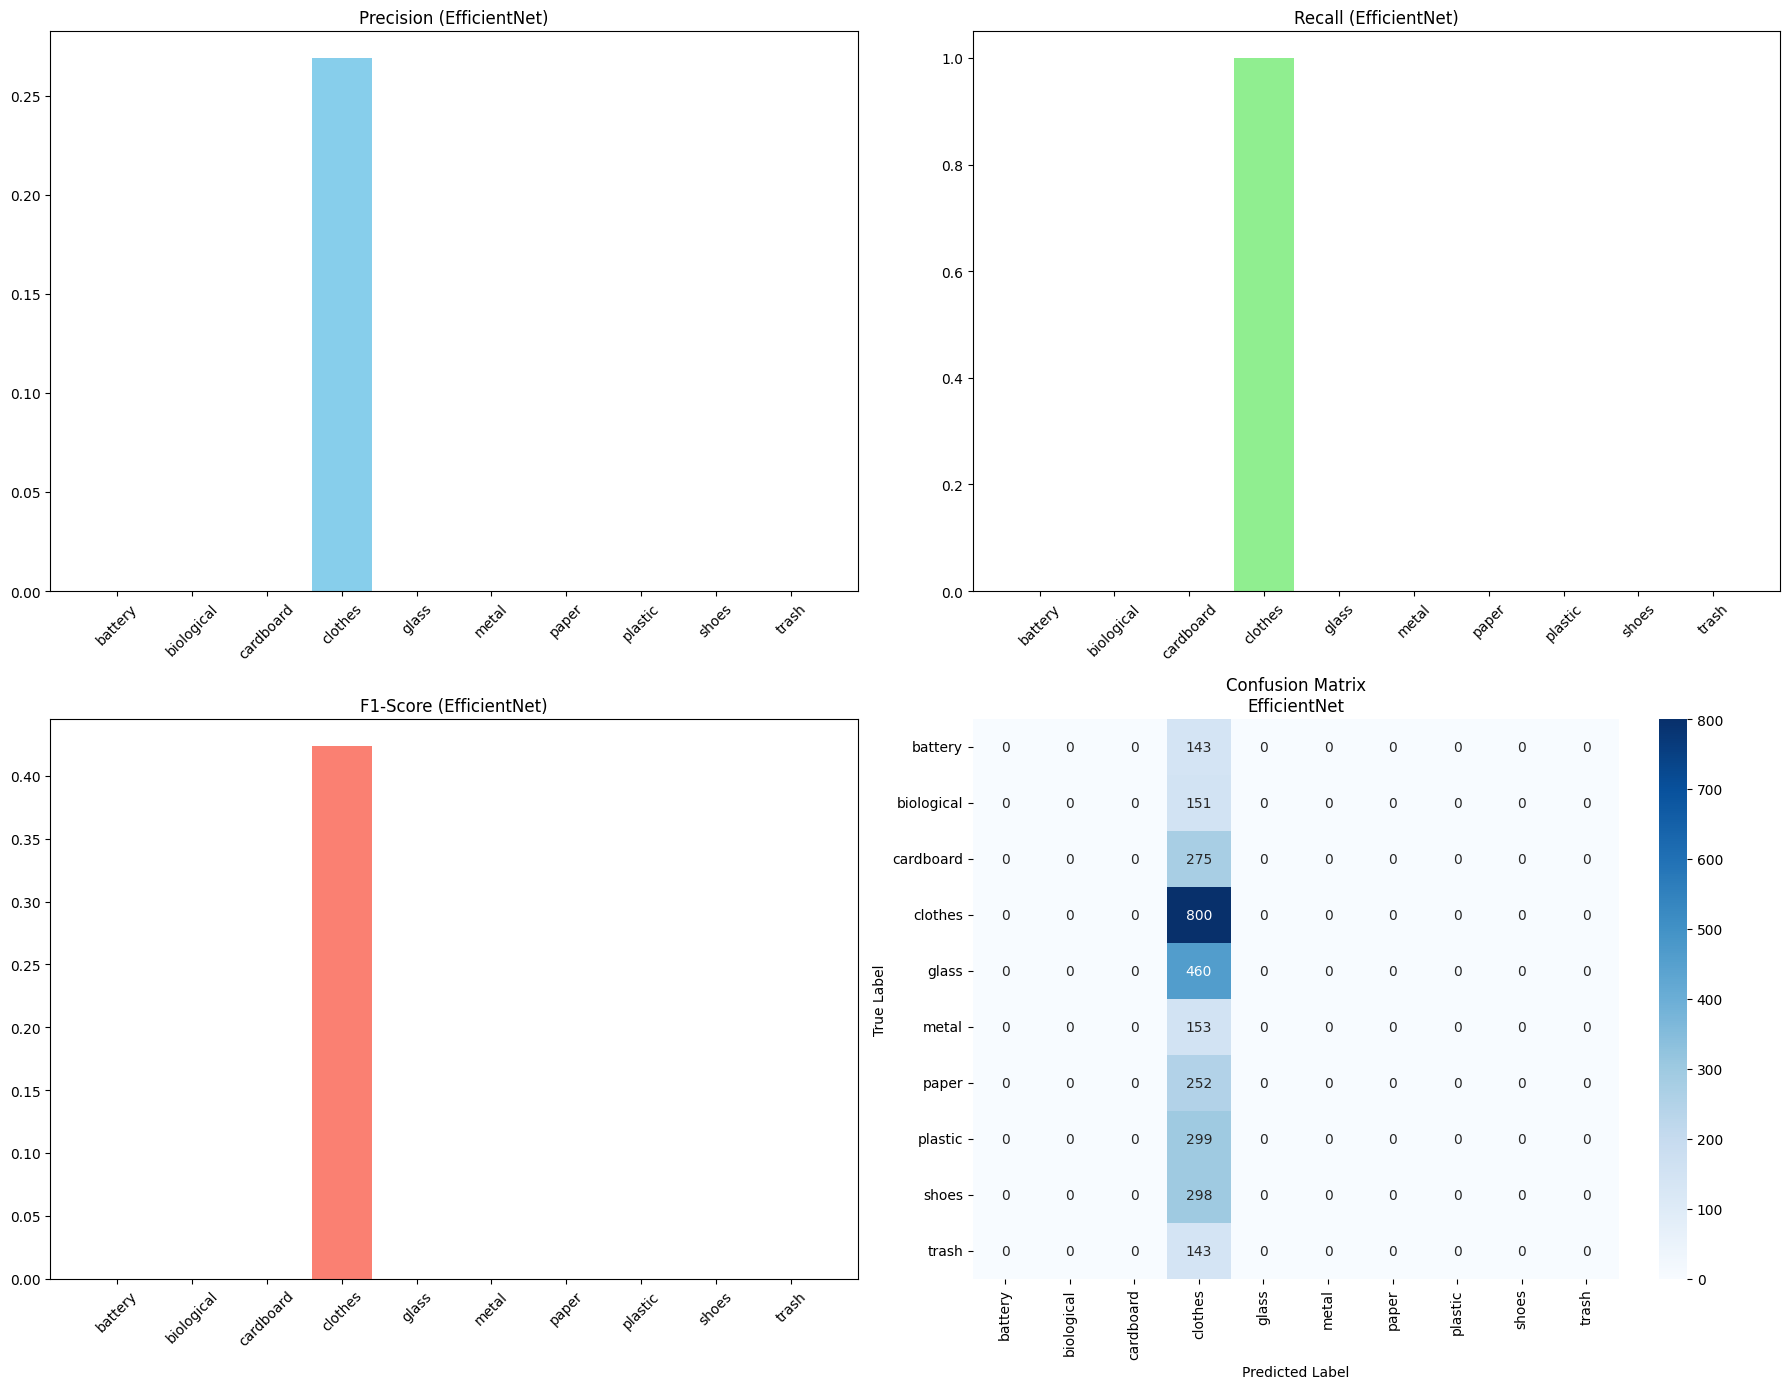

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def get_metrics(y_true, y_pred, class_names):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, zero_division=0)
    return pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

def plot_confusion_matrix(cm, class_names, model_name, ax):
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(f'Confusion Matrix\n{model_name}')

def evaluate_and_plot(model, test_generator, class_names, model_name):
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes
    
    metrics_df = get_metrics(y_true, y_pred_classes, class_names)
    cm = confusion_matrix(y_true, y_pred_classes)
    
    return metrics_df, cm

# Klassennamen
class_names = list(test_generator.class_indices.keys())

# EfficientNet evaluieren
metrics_efficientnet, cm_efficientnet = evaluate_and_plot(efficientnet_model, test_generator, class_names, "EfficientNet")

# Balkendiagramme
fig, axs = plt.subplots(2, 2, figsize=(18, 14))
x = np.arange(len(class_names))

axs[0, 0].bar(x, metrics_efficientnet['Precision'], color='skyblue')
axs[0, 0].set_xticks(x)
axs[0, 0].set_xticklabels(class_names, rotation=45)
axs[0, 0].set_title('Precision (EfficientNet)')

axs[0, 1].bar(x, metrics_efficientnet['Recall'], color='lightgreen')
axs[0, 1].set_xticks(x)
axs[0, 1].set_xticklabels(class_names, rotation=45)
axs[0, 1].set_title('Recall (EfficientNet)')

axs[1, 0].bar(x, metrics_efficientnet['F1-Score'], color='salmon')
axs[1, 0].set_xticks(x)
axs[1, 0].set_xticklabels(class_names, rotation=45)
axs[1, 0].set_title('F1-Score (EfficientNet)')

# Confusion Matrix
plot_confusion_matrix(cm_efficientnet, class_names, "EfficientNet", axs[1, 1])

plt.tight_layout()
plt.show()

#hat schlecht trainiert, weil Bilder falsche Skalierung für dieses Modell hatte

In [43]:
from tensorflow.keras.applications.efficientnet import preprocess_input

# ImageDataGenerator für Trainingsdaten mit Augmentation
train_datagen_efficientnet = ImageDataGenerator(
    preprocessing_function=preprocess_input, #erwartet andere Skalierung [-1,+1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Für Validation und Test nur Normalisierung
val_test_datagen_efficientt = ImageDataGenerator(preprocessing_function=preprocess_input)

# Trainingsdaten generieren
train_generator_for_efficientnet = train_datagen_efficientnet.flow_from_directory(
    directory=f"{base_dir}/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

# Validierungsdaten generieren
val_generator_for_efficientnet = val_test_datagen_efficientt.flow_from_directory(
    directory=f"{base_dir}/val",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

# Testdaten generieren
test_generator_for_efficientnet = val_test_datagen_efficientt.flow_from_directory(
    directory=f"{base_dir}/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 13827 images belonging to 10 classes.
Found 2961 images belonging to 10 classes.
Found 2974 images belonging to 10 classes.


In [ ]:
from tensorflow.keras import callbacks

# EarlyStopping Callback definieren
early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy',     # auf Validierungsgenauigkeit achten
    patience=3,                 # nach 3 Epochen ohne Verbesserung stoppen
    restore_best_weights=True  # beste Modellgewichte wiederherstellen
)

# Neuen Namen 
efficientnet_new_preprocess_model = models.Sequential([
    base_efficientnet_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

efficientnet_new_preprocess_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

efficientnet_new_preprocess_model.summary()

# Training
efficientnet_history = efficientnet_new_preprocess_model.fit(
    train_generator_for_efficientnet,
    validation_data=val_generator_for_efficientnet,
    epochs=10,
    callbacks=[early_stopping]
    )

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 2,063,514 (7.87 MB)

 Non-trainable params: 1,998,867 (7.63 MB)

Epoch 1/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 474s 1s/step - accuracy: 0.9307 - loss: 0.2640 - val_accuracy: 0.9504 - val_loss: 0.2127
Epoch 2/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 454s 1s/step - accuracy: 0.9754 - loss: 0.0803 - val_accuracy: 0.9629 - val_loss: 0.1499
Epoch 3/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 455s 1s/step - accuracy: 0.9806 - loss: 0.0650 - val_accuracy: 0.9608 - val_loss: 0.1725
Epoch 4/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 454s 1s/step - accuracy: 0.9833 - loss: 0.0556 - val_accuracy: 0.9608 - val_loss: 0.1643
Epoch 5/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 454s 1s/step - accuracy: 0.9837 - loss: 0.0540 - val_accuracy: 0.9510 - val_loss: 0.2473


C:\Users\rusla\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 67s 717ms/step


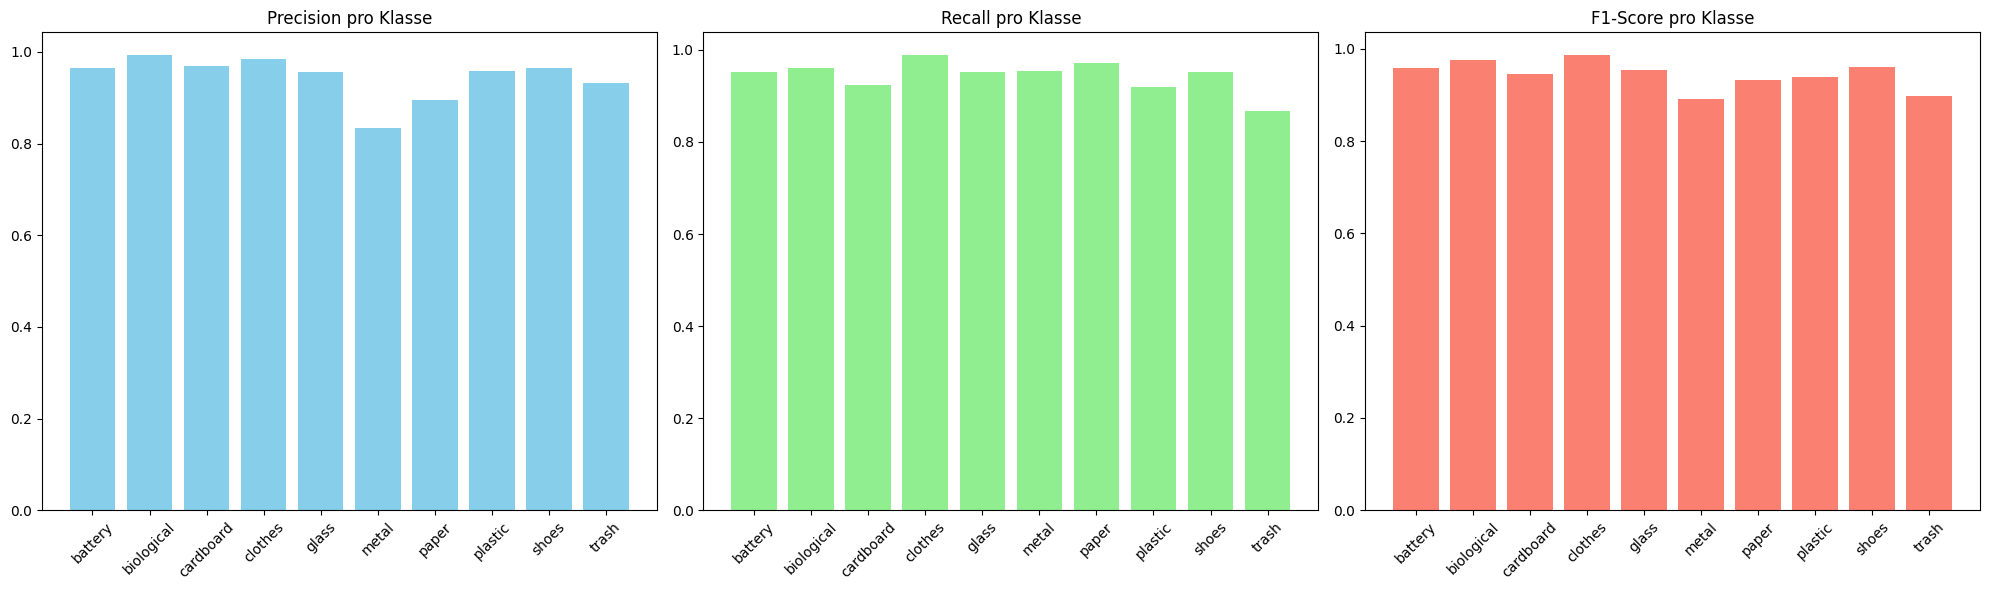

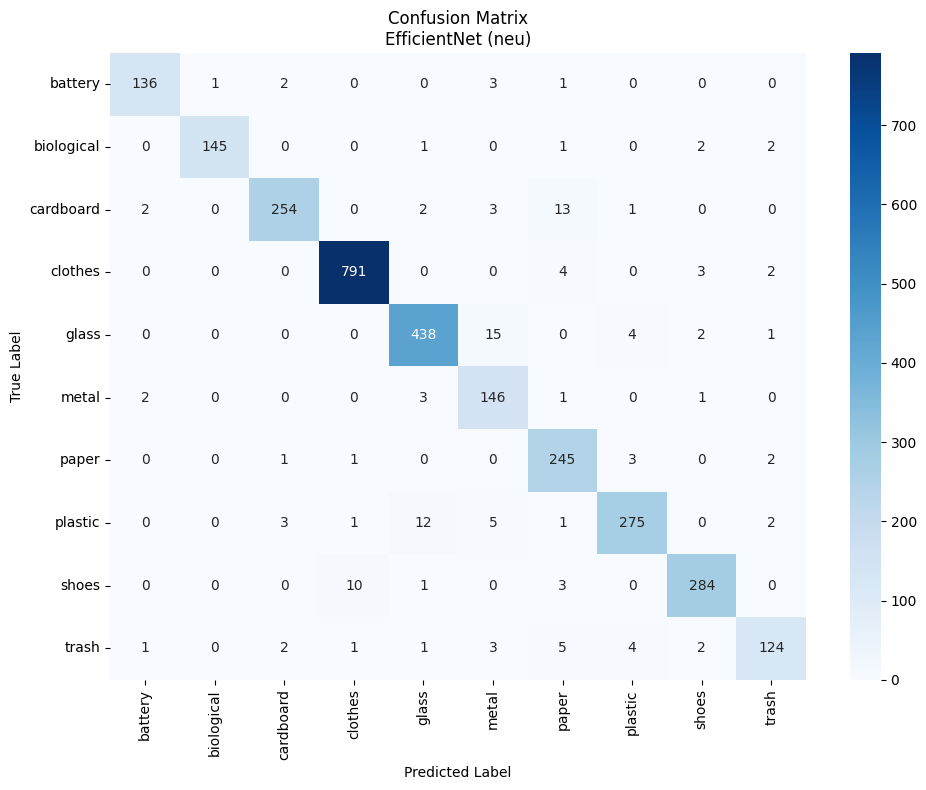

In [44]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ==== Hilfsfunktionen ====

def get_metrics(y_true, y_pred, class_names):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, zero_division=0)
    return pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

def plot_confusion_matrix(cm, class_names, model_name, ax):
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(f'Confusion Matrix\n{model_name}')

def evaluate_and_plot(model, test_generator, class_names, model_name):
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes
    
    metrics_df = get_metrics(y_true, y_pred_classes, class_names)
    cm = confusion_matrix(y_true, y_pred_classes)
    
    return metrics_df, cm

# ==== Modellbewertung ====

# Klassennamen aus dem Generator holen
class_names = list(test_generator.class_indices.keys())

# Evaluate dein neues EfficientNet-Modell
metrics_efficientnet, cm_efficientnet = evaluate_and_plot(efficientnet_new_preprocess_model, test_generator_for_efficientnet, class_names, "EfficientNet")

# ==== Plotten ====

# Barplot mit Precision, Recall, F1
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
x = np.arange(len(class_names))

axs[0].bar(x, metrics_efficientnet['Precision'], color='skyblue')
axs[0].set_xticks(x)
axs[0].set_xticklabels(class_names, rotation=45)
axs[0].set_title('Precision pro Klasse')

axs[1].bar(x, metrics_efficientnet['Recall'], color='lightgreen')
axs[1].set_xticks(x)
axs[1].set_xticklabels(class_names, rotation=45)
axs[1].set_title('Recall pro Klasse')

axs[2].bar(x, metrics_efficientnet['F1-Score'], color='salmon')
axs[2].set_xticks(x)
axs[2].set_xticklabels(class_names, rotation=45)
axs[2].set_title('F1-Score pro Klasse')

plt.tight_layout()
plt.show()

# Confusion Matrix plotten
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cm_efficientnet, class_names, "EfficientNet (neu)", plt.gca())
plt.tight_layout()
plt.show()


In [48]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def get_metrics(y_true, y_pred, class_names):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, zero_division=0)
    return pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

def plot_confusion_matrix(cm, class_names, model_name, ax):
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(f'Confusion Matrix\n{model_name}')

def evaluate_and_plot(model, test_generator, class_names, model_name):
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes
    
    metrics_df = get_metrics(y_true, y_pred_classes, class_names)
    cm = confusion_matrix(y_true, y_pred_classes)
    
    return metrics_df, cm

# Klassennamen
class_names = list(test_generator.class_indices.keys())

# Modelle evaluieren
metrics_mobilenetv2, cm_mobilenetv2 = evaluate_and_plot(mobilenetv2_model, test_generator, class_names, "MobileNetV2")
metrics_own_cnn, cm_own_cnn = evaluate_and_plot(model, test_generator, class_names, "Eigenes CNN")
metrics_efficientnet, cm_efficientnet = evaluate_and_plot(efficientnet_new_preprocess_model, test_generator_for_efficientnet, class_names, "EfficientNet")

# Funktion zum Umbenennen der Metriken-Spalten
def rename_metrics_df(df, suffix):
    return df.rename(columns={
        'Precision': f'Precision_{suffix}',
        'Recall': f'Recall_{suffix}',
        'F1-Score': f'F1-Score_{suffix}'
    }).set_index('Class')

# Umbenennen
metrics_mobilenetv2_renamed = rename_metrics_df(metrics_mobilenetv2, 'MobileNetV2')
metrics_own_cnn_renamed = rename_metrics_df(metrics_own_cnn, 'OwnCNN')
metrics_efficientnet_renamed = rename_metrics_df(metrics_efficientnet, 'EfficientNet')

# Zusammenfügen aller Metriken
metrics_compare = metrics_mobilenetv2_renamed.join(
    metrics_own_cnn_renamed, how='outer'
).join(
    metrics_efficientnet_renamed, how='outer'
).reset_index()

print(metrics_compare)

93/93 ━━━━━━━━━━━━━━━━━━━━ 53s 573ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 17s 182ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 67s 722ms/step
        Class  Precision_MobileNetV2  Recall_MobileNetV2  \
0     battery               0.963235            0.916084   
1  biological               0.972973            0.953642   
2   cardboard               0.917391            0.767273   
3     clothes               0.978829            0.982500   
4       glass               0.963680            0.865217   
5       metal               0.731579            0.908497   
6       paper               0.753994            0.936508   
7     plastic               0.852941            0.872910   
8       shoes               0.915361            0.979866   
9       trash               0.913793            0.741259   

   F1-Score_MobileNetV2  Precision_OwnCNN  Recall_OwnCNN  F1-Score_OwnCNN  \
0              0.939068          0.659420       0.636364         0.647687   
1              0.963211          0.744828       0.715232   

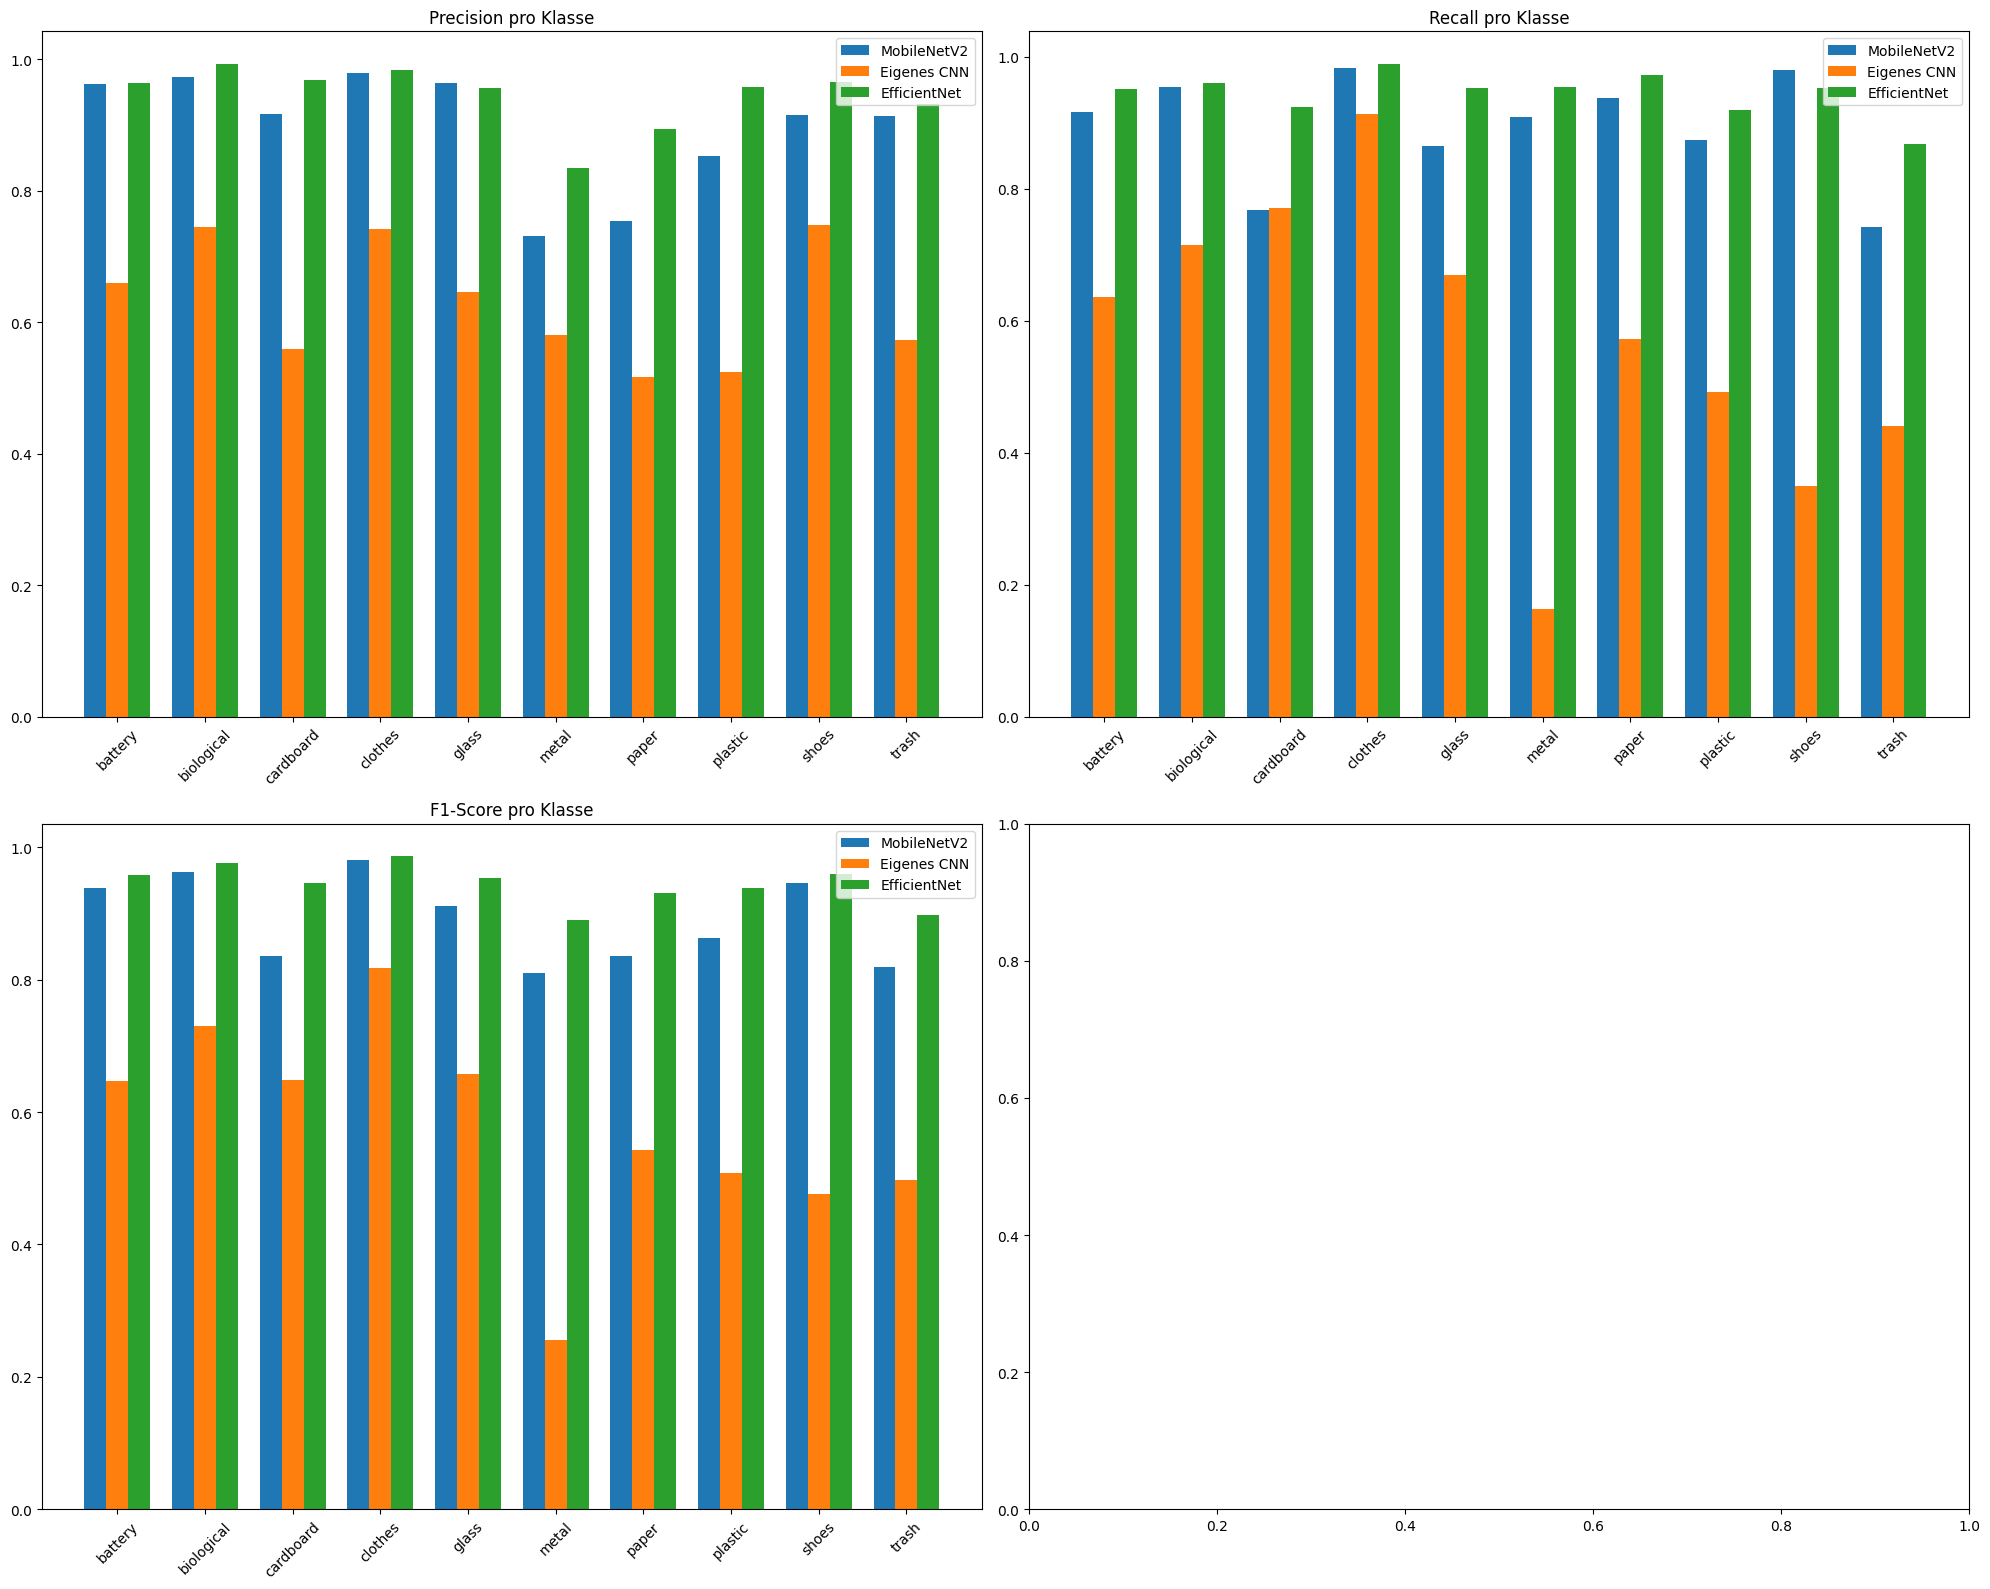

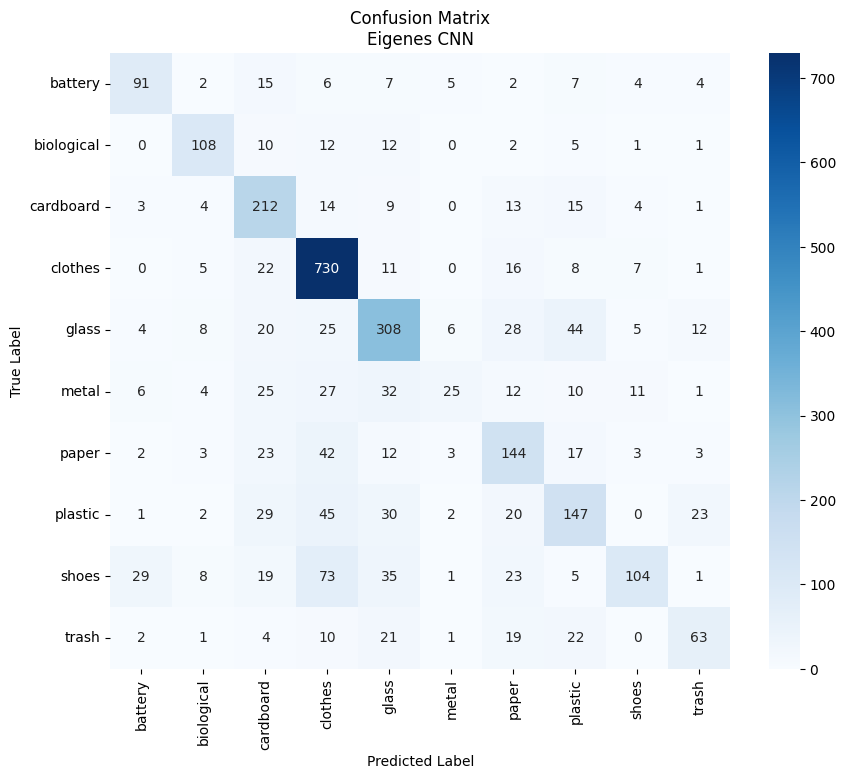

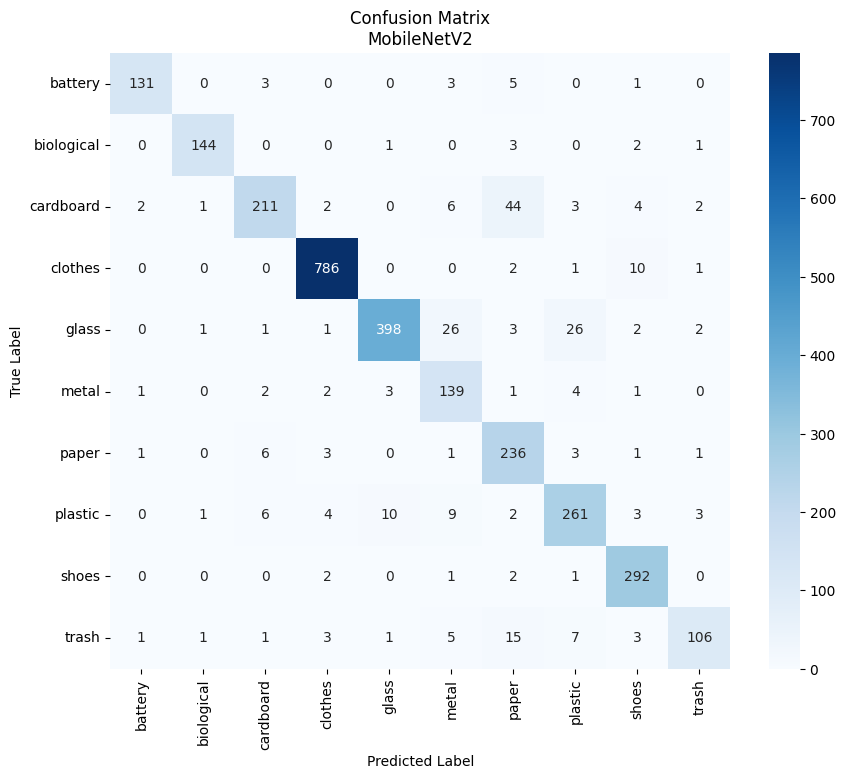

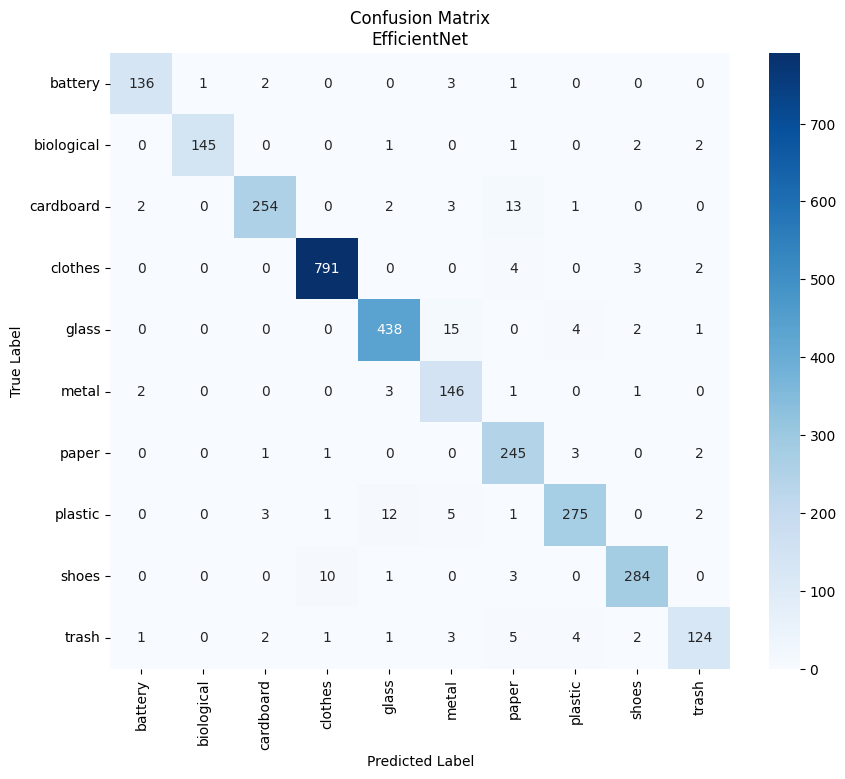

In [49]:
# Plot
fig, axs = plt.subplots(2, 2, figsize=(20, 16))
width = 0.25
x = np.arange(len(class_names))

# Precision
axs[0, 0].bar(x - width, metrics_compare['Precision_MobileNetV2'], width, label='MobileNetV2')
axs[0, 0].bar(x, metrics_compare['Precision_OwnCNN'], width, label='Eigenes CNN')
axs[0, 0].bar(x + width, metrics_compare['Precision_EfficientNet'], width, label='EfficientNet')
axs[0, 0].set_xticks(x)
axs[0, 0].set_xticklabels(class_names, rotation=45)
axs[0, 0].set_title('Precision pro Klasse')
axs[0, 0].legend()

# Recall
axs[0, 1].bar(x - width, metrics_compare['Recall_MobileNetV2'], width, label='MobileNetV2')
axs[0, 1].bar(x, metrics_compare['Recall_OwnCNN'], width, label='Eigenes CNN')
axs[0, 1].bar(x + width, metrics_compare['Recall_EfficientNet'], width, label='EfficientNet')
axs[0, 1].set_xticks(x)
axs[0, 1].set_xticklabels(class_names, rotation=45)
axs[0, 1].set_title('Recall pro Klasse')
axs[0, 1].legend()

# F1-Score
axs[1, 0].bar(x - width, metrics_compare['F1-Score_MobileNetV2'], width, label='MobileNetV2')
axs[1, 0].bar(x, metrics_compare['F1-Score_OwnCNN'], width, label='Eigenes CNN')
axs[1, 0].bar(x + width, metrics_compare['F1-Score_EfficientNet'], width, label='EfficientNet')
axs[1, 0].set_xticks(x)
axs[1, 0].set_xticklabels(class_names, rotation=45)
axs[1, 0].set_title('F1-Score pro Klasse')
axs[1, 0].legend()

plt.tight_layout()
plt.show()

# Optional: Weitere Confusion Matrices separat plotten
plt.figure(figsize=(10,8))
plot_confusion_matrix(cm_own_cnn, class_names, "Eigenes CNN", plt.gca())
plt.show()

plt.figure(figsize=(10,8))
plot_confusion_matrix(cm_mobilenetv2, class_names, "MobileNetV2", plt.gca())
plt.show()

plt.figure(figsize=(10,8))
plot_confusion_matrix(cm_efficientnet, class_names, "EfficientNet", plt.gca())
plt.show()

In [ ]:
model.save("own_cnn_model.keras")
mobilenetv2_model.save("mobilenetv2_model.keras")
efficientnet_new_preprocess_model.save("efficientnet_model.keras")

In [55]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import callbacks
from tensorflow.keras.applications.resnet50 import preprocess_input

# ImageDataGenerator für Trainingsdaten mit Augmentation
train_datagen_resnet = ImageDataGenerator(
    preprocessing_function=preprocess_input, #erwartet andere Skalierung [-1,+1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Für Validation und Test nur Normalisierung
val_test_datagen_resnet = ImageDataGenerator(preprocessing_function=preprocess_input)

# Trainingsdaten generieren
train_generator_for_resnet = train_datagen_resnet.flow_from_directory(
    directory=f"{base_dir}/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

# Validierungsdaten generieren
val_generator_for_resnet = val_test_datagen_resnet.flow_from_directory(
    directory=f"{base_dir}/val",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

# Testdaten generieren
test_generator_for_resnet = val_test_datagen_resnet.flow_from_directory(
    directory=f"{base_dir}/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

# ResNet50 laden ohne Klassifikationskopf
base_resnet_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Basis-Modell einfrieren (nur Kopf trainierbar)
base_resnet_model.trainable = False

# Modell bauen
resnet_model = models.Sequential([
    base_resnet_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')  # Anzahl Klassen anpassen
])

resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

resnet_model.summary()

# EarlyStopping Callback definieren
early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy',     # auf Validierungsgenauigkeit achten
    patience=3,                 # nach 3 Epochen ohne Verbesserung stoppen
    restore_best_weights=True  # beste Modellgewichte wiederherstellen
)

# Training
history_resnet = resnet_model.fit(
    train_generator_for_resnet,
    validation_data=val_generator_for_resnet,
    epochs=10,
    callbacks=[early_stopping]
    )

Found 13827 images belonging to 10 classes.
Found 2961 images belonging to 10 classes.
Found 2974 images belonging to 10 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

C:\Users\rusla\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 836s 2s/step - accuracy: 0.7367 - loss: 0.8531 - val_accuracy: 0.9098 - val_loss: 0.2835
Epoch 2/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 667s 2s/step - accuracy: 0.9072 - loss: 0.2875 - val_accuracy: 0.9314 - val_loss: 0.2194
Epoch 3/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 651s 2s/step - accuracy: 0.9199 - loss: 0.2434 - val_accuracy: 0.9291 - val_loss: 0.2233
Epoch 4/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 650s 2s/step - accuracy: 0.9236 - loss: 0.2229 - val_accuracy: 0.9345 - val_loss: 0.2037
Epoch 5/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 650s 2s/step - accuracy: 0.9250 - loss: 0.2143 - val_accuracy: 0.9416 - val_loss: 0.2002
Epoch 6/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 653s 2s/step - accuracy: 0.9283 - loss: 0.2137 - val_accuracy: 0.9382 - val_loss: 0.1990
Epoch 7/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 654s 2s/step - accuracy: 0.9348 - loss: 0.1921 - val_accuracy: 0.9368 - val_loss: 0.2119
Epoch 8/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 653s 2s/step - accuracy: 0.9292 - loss: 0.2021 - val_accu

In [56]:
resnet_model.save("resnet_model.keras")

C:\Users\rusla\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step


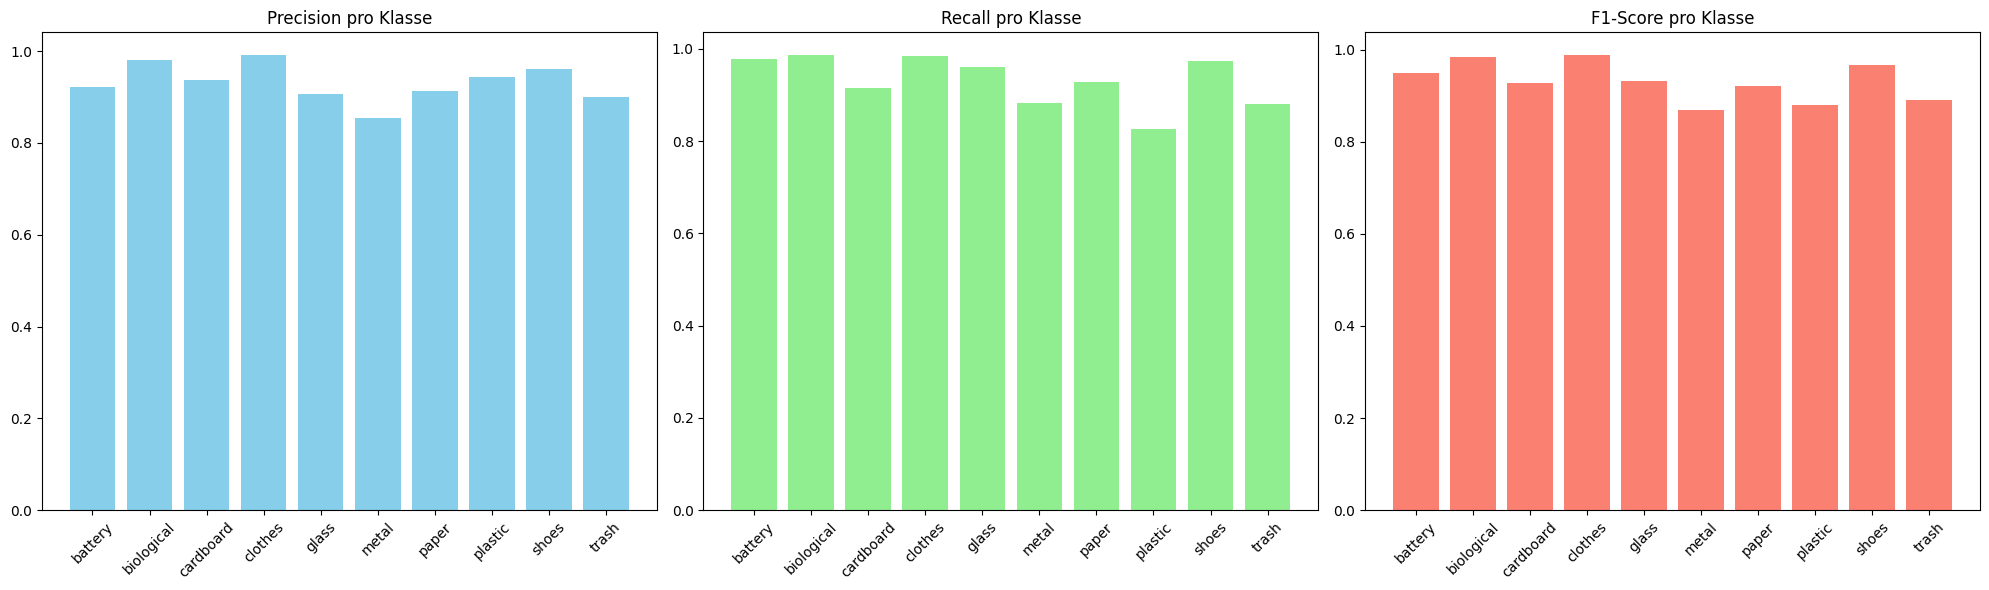

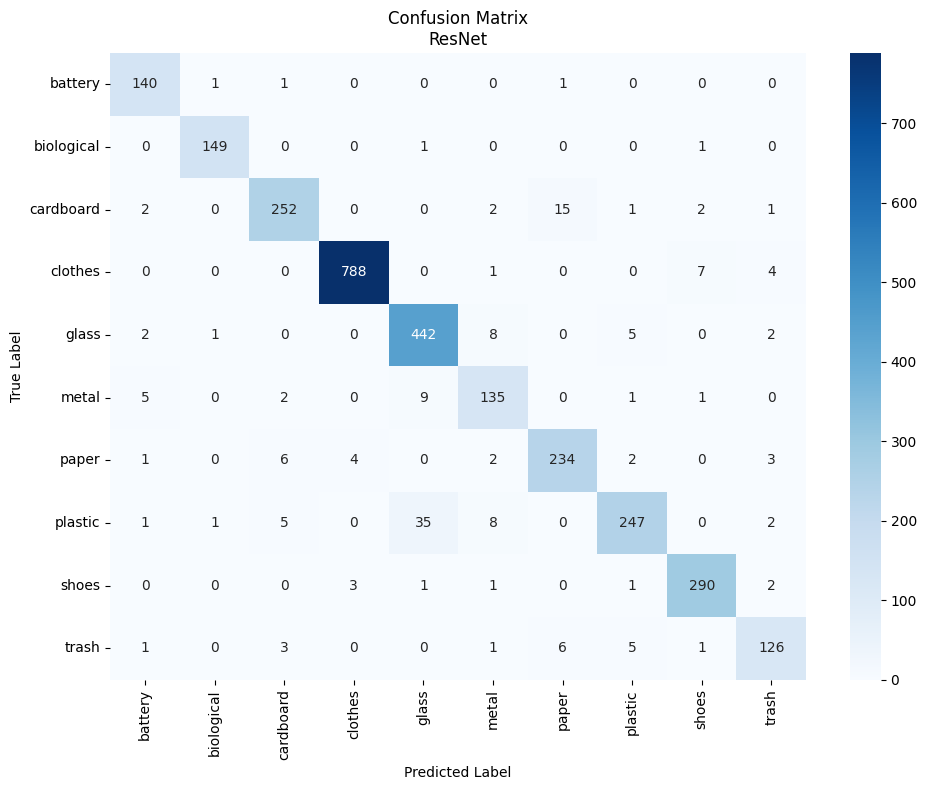

In [57]:
# ==== Modellbewertung ====

# Klassennamen aus dem Generator holen
class_names = list(test_generator.class_indices.keys())

# Evaluate dein neues EfficientNet-Modell
metrics_resnet, cm_resnet = evaluate_and_plot(resnet_model, test_generator_for_resnet, class_names, "ResNet")

# ==== Plotten ====

# Barplot mit Precision, Recall, F1
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
x = np.arange(len(class_names))

axs[0].bar(x, metrics_resnet['Precision'], color='skyblue')
axs[0].set_xticks(x)
axs[0].set_xticklabels(class_names, rotation=45)
axs[0].set_title('Precision pro Klasse')

axs[1].bar(x, metrics_resnet['Recall'], color='lightgreen')
axs[1].set_xticks(x)
axs[1].set_xticklabels(class_names, rotation=45)
axs[1].set_title('Recall pro Klasse')

axs[2].bar(x, metrics_resnet['F1-Score'], color='salmon')
axs[2].set_xticks(x)
axs[2].set_xticklabels(class_names, rotation=45)
axs[2].set_title('F1-Score pro Klasse')

plt.tight_layout()
plt.show()

# Confusion Matrix plotten
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cm_resnet, class_names, "ResNet", plt.gca())
plt.tight_layout()
plt.show()


In [58]:
print(metrics_resnet)

        Class  Precision    Recall  F1-Score
0     battery   0.921053  0.979021  0.949153
1  biological   0.980263  0.986755  0.983498
2   cardboard   0.936803  0.916364  0.926471
3     clothes   0.991195  0.985000  0.988088
4       glass   0.905738  0.960870  0.932489
5       metal   0.854430  0.882353  0.868167
6       paper   0.914062  0.928571  0.921260
7     plastic   0.942748  0.826087  0.880570
8       shoes   0.960265  0.973154  0.966667
9       trash   0.900000  0.881119  0.890459
